In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle
! cp '/content/drive/MyDrive/kaggle.json' ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
drive_project_folder_path='/content/drive/MyDrive/CAPSTONE_PROJECT_MLAI'

In [ ]:
! kaggle datasets download shyambhu/hands-and-palm-images-dataset
! cp -r  "/content/hands-and-palm-images-dataset.zip" "/content/drive/MyDrive/CAPSTONE_PROJECT_MLAI/hands-and-palm-images-dataset.zip"

100% 632M/634M [00:29<00:00, 24.8MB/s]
100% 634M/634M [00:29<00:00, 22.5MB/s]


In [ ]:
!unzip hands-and-palm-images-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Hands/Hands/Hand_0006508.jpg  
  inflating: Hands/Hands/Hand_0006509.jpg  
  inflating: Hands/Hands/Hand_0006510.jpg  
  inflating: Hands/Hands/Hand_0006511.jpg  
  inflating: Hands/Hands/Hand_0006512.jpg  
  inflating: Hands/Hands/Hand_0006513.jpg  
  inflating: Hands/Hands/Hand_0006514.jpg  
  inflating: Hands/Hands/Hand_0006515.jpg  
  inflating: Hands/Hands/Hand_0006516.jpg  
  inflating: Hands/Hands/Hand_0006517.jpg  
  inflating: Hands/Hands/Hand_0006518.jpg  
  inflating: Hands/Hands/Hand_0006519.jpg  
  inflating: Hands/Hands/Hand_0006520.jpg  
  inflating: Hands/Hands/Hand_0006521.jpg  
  inflating: Hands/Hands/Hand_0006522.jpg  
  inflating: Hands/Hands/Hand_0006523.jpg  
  inflating: Hands/Hands/Hand_0006524.jpg  
  inflating: Hands/Hands/Hand_0006525.jpg  
  inflating: Hands/Hands/Hand_0006526.jpg  
  inflating: Hands/Hands/Hand_0006527.jpg  
  inflating: Hands/Hands/Hand_0006528.jpg  
  inflating: Hands/Hands/

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

In [ ]:
import pandas as pd
dataset_dir_path='/content/Hands/Hands'
df=pd.read_csv('HandInfo.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11076 entries, 0 to 11075
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              11076 non-null  int64 
 1   age             11076 non-null  int64 
 2   gender          11076 non-null  object
 3   skinColor       11076 non-null  object
 4   accessories     11076 non-null  int64 
 5   nailPolish      11076 non-null  int64 
 6   aspectOfHand    11076 non-null  object
 7   imageName       11076 non-null  object
 8   irregularities  11076 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 778.9+ KB


In [ ]:
def get_col_val_list_in_alphabetical_order_file_names_dict(dataset_dir_path,csv_df):

    '''
    this function is needed in order to make the list of target labels to give as labels argument of
     the keras.utils.image_dataset_from_directory function.
     The keras.utils.image_dataset_from_directory function makes a tensorflow dataset object from the images inside
     a folder. the labels argument should be a list of target variables corresponding to images filenames as listed by
     os.walk('dataset_directory_path') function.

    So what this function does is, to output a dictionary. The dictionary takes the column names in the HandInfo.csv as keys.
    The value in the dictionary corresponding to the column name given as key in the dictionary, is a list,
    containing all the rows in the csv for that single column. The thing is the the rows in this list are ordered such
    that they correspond to the image_file in the order outputted by os.walk('dataset_directory_path').





    '''
    df=csv_df.set_index('imageName')

    from os import walk ## see https://hyp.is/DAhG1PfzEe2Qw3vXNIwQ3Q/www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
    # print(list(walk(dataset_dir_path))[0][2][0])
    img_filenames_list=list(walk(dataset_dir_path))[0][2]
    col_val_list_in_order_file_names_dict={}


    for col in df.columns.to_list():
        col_val_list_in_order_file_names_dict[col]=[]

        for filename in img_filenames_list:

            col_val_list_in_order_file_names_dict[col].append(df[col][filename])
    return col_val_list_in_order_file_names_dict


### execute the function to get the dictionary
col_val_list_in_order_file_names_dict=get_col_val_list_in_alphabetical_order_file_names_dict(dataset_dir_path,csv_df=df)

In [ ]:
### get the num of color channels in the images
def find_num_channels_in_imgs(dataset_dir_path):
    from os import walk ## see https://hyp.is/DAhG1PfzEe2Qw3vXNIwQ3Q/www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

    import cv2
    first_img_np=cv2.imread(f'{dataset_dir_path}/{list(walk(dataset_dir_path))[0][2][0]}')
    return first_img_np.shape[-1]
num_channels=find_num_channels_in_imgs(dataset_dir_path)

In [ ]:
### to get target labels for image_files in order as listed by os.walk('dataset_directory_path')
### in order to use it in keras.utils.image_dataset_from_directory
y_gen_nonenc=col_val_list_in_order_file_names_dict['gender']

### function to encode y_gen_nonenc to binary values
def encode_labels(y_nonenc,categories_list):
    from sklearn.preprocessing import OrdinalEncoder
    y_nonenc=np.array(y_nonenc).reshape(-1,1)
    oe=OrdinalEncoder(categories=[categories_list]) ## so that we know which category is 0 and 1; here male will be encoded as 0 and female 1
    y_enc_np=oe.fit_transform(y_nonenc)
    return y_enc_np

y_gen_enc_np=encode_labels(y_gen_nonenc,['male','female'])

In [ ]:
img_resize_shape=(240,320)
img_size_tuple=(img_resize_shape[0],img_resize_shape[1],num_channels)

test_fraction=0.2
seed=12
'''
The keras.utils.image_dataset_from_directory function makes a tensorflow dataset object from the images inside
a folder.
see https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
 the labels argument should be a list of target variables corresponding to images filenames as listed by
os.walk('dataset_directory_path') function.
'''

train_img_set_tfds, test_img_set_tfds=image_dataset_from_directory(
    dataset_dir_path,
    labels=y_gen_enc_np.flatten().tolist(),
    # labels=None,

    validation_split=test_fraction,
    subset='both',
    seed=seed,
    image_size=img_resize_shape,
    batch_size=8
    )

### to make a smaller dataset to do trial and error training ; so that the epochs will finish faster
small_train=train_img_set_tfds.take(400) ## 400 is the number of batches

Found 11076 files belonging to 2 classes.
Using 8861 files for training.
Using 2215 files for validation.


In [ ]:
### just to check if the contents of the tensorflow dataset obj are correct and  as intended

'''
count=0
for i,j in small_train:
    count+=1
    if count==1:
        print(i.numpy().shape) ### (batch_size, img_height, img_width, channels)
        print(j.numpy()) ## outputs labels for one batch

    else:
        break
# print(count)
'''

'\ncount=0\nfor i,j in small_train:\n    count+=1\n    if count==1:\n        print(i.numpy().shape) ### (batch_size, img_height, img_width, channels)\n        print(j.numpy()) ## outputs labels for one batch\n\n    else:\n        break\n# print(count)\n'

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Input, Dense, concatenate, Conv2D, MaxPooling2D, Dropout, Rescaling, RandomFlip, RandomRotation

In [ ]:
!pip install keras_cv &> /dev/null
import keras_cv

In [ ]:
img_size_tuple=(img_resize_shape[0],img_resize_shape[1],num_channels)

print(img_size_tuple )

(240, 320, 3)


In [ ]:
small_train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 240, 320, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [ ]:
test_img_set_tfds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 240, 320, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [ ]:
import tensorflow.keras as keras

Densenet code

In [ ]:
'''
Dense net is densely connected-convolutional networks.
DenseNet was specially developed to improve accuracy caused by the vanishing gradient in high-level neural networks due to the long distance between input and output layers &
the information vanishes before reaching its destination.
'''

'\nDense net is densely connected-convolutional networks.\nDenseNet was specially developed to improve accuracy caused by the vanishing gradient in high-level neural networks due to the long distance between input and output layers & \nthe information vanishes before reaching its destination.\n'

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import Model

In [ ]:
'''
The dense_block function is a key component of the DenseNet architecture. It defines a block that consists of multiple dense layers.
The purpose of the dense_block function is to create a block of dense layers within the DenseNet architecture.
By stacking multiple instances of this block together, the network can effectively learn feature representations at different scales and depths, promoting information flow and gradient propagation throughout the network.
'''

'\nThe dense_block function is a key component of the DenseNet architecture. It defines a block that consists of multiple dense layers.\nThe purpose of the dense_block function is to create a block of dense layers within the DenseNet architecture. \nBy stacking multiple instances of this block together, the network can effectively learn feature representations at different scales and depths, promoting information flow and gradient propagation throughout the network.\n'

In [ ]:
def dense_block(x, growth_rate, num_layers):
    for _ in range(num_layers):
        # Bottleneck layer
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(4 * growth_rate, kernel_size=(1, 1), padding='same')(x)  #1*1 convolution

        # Composite function
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(growth_rate, kernel_size=(3, 3), padding='same')(x)

        # Concatenate with input
        x = tf.keras.layers.Concatenate()([x, x])
    return x

In [ ]:
#The transition_block function defines a block that performs a transition between two dense blocks by reducing the spatial dimensions and the number of channels.
'''
The purpose of the transition_block function is to introduce a transition between two dense blocks in the DenseNet architecture.
It compresses the information and reduces the spatial dimensions, allowing for a more compact representation and aiding in the efficient flow of information through the network.
'''
def transition_block(x, reduction):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(int(tf.keras.backend.int_shape(x)[3] * reduction), kernel_size=(1, 1), padding='same')(x)
    x = AveragePooling2D(pool_size=(2, 2), strides=2)(x)
    return x

In [ ]:
'''
The create_densenet function is used to create a DenseNet model given the input shape, number of classes, growth rate, number of blocks, and reduction factor.
'''

def create_densenet(input_shape, num_classes, growth_rate=32, num_blocks=[6, 12, 24, 16], reduction=0.5):  # 4 dense blocks with layers as 6,12,24,16 respectively
    inputs = tf.keras.Input(shape=input_shape)

    # Initial convolution
    x = Conv2D(2 * growth_rate, kernel_size=(7, 7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Dense blocks and transition blocks
    for block in num_blocks:
        x = dense_block(x, growth_rate, block)
        x = transition_block(x, reduction)

    # Final blocks
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)

    # Classification layer
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

In [ ]:
# Create the DenseNet model
input_shape = (240, 320, 3)  #according to image size
num_classes = 2  # two genders, male and female
model = create_densenet(input_shape, num_classes)

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 120, 160, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 120, 160, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
model.fit(
    # train_img_set_tfds,
    small_train,
    # y=y_gen_enc,
    epochs=50,
    validation_data=test_img_set_tfds,
    # batch_size=5,
    class_weight={0:(1/3967), 1:(1/7109)}
    #callbacks=[callbacks_list]
)

Epoch 1/50
400/400 [==============================] - 182s 186ms/step - loss: 1.2602e-04 - accuracy: 0.4884 - val_loss: 0.6850 - val_accuracy: 0.6497
Epoch 2/50
400/400 [==============================] - 80s 199ms/step - loss: 1.2532e-04 - accuracy: 0.5294 - val_loss: 0.7769 - val_accuracy: 0.6488
Epoch 3/50
400/400 [==============================] - 78s 195ms/step - loss: 1.2515e-04 - accuracy: 0.5225 - val_loss: 0.7575 - val_accuracy: 0.3847
Epoch 4/50
400/400 [==============================] - 74s 182ms/step - loss: 1.2483e-04 - accuracy: 0.5609 - val_loss: 6.8689 - val_accuracy: 0.6497
Epoch 5/50
400/400 [==============================] - 73s 181ms/step - loss: 1.2507e-04 - accuracy: 0.5434 - val_loss: 1.2886 - val_accuracy: 0.6497
Epoch 6/50
400/400 [==============================] - 76s 188ms/step - loss: 1.2515e-04 - accuracy: 0.5572 - val_loss: 0.9060 - val_accuracy: 0.6510
Epoch 7/50
400/400 [==============================] - 80s 199ms/step - loss: 1.2503e-04 - accuracy: 0.560

# **Checking Predictions**

In [ ]:
import cv2
import numpy as np

In [ ]:
# Preprocess the image
image4 = cv2.imread('priya_left2.jpg')
image4 = cv2.resize(image4, (320, 240))
image4 = image4 / 255.0  # Normalize pixel values to [0, 1]

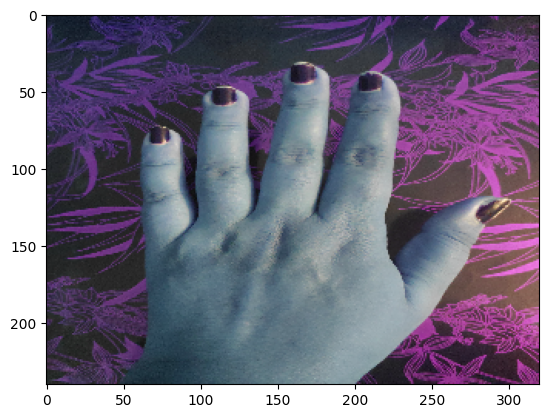

In [ ]:
plt.imshow(image4)
plt.show();

In [ ]:
# Make predictions
prediction4 = model.predict(np.expand_dims(image4, axis=0))
predicted_class4 = np.argmax(prediction4)

1/1 [==============================] - 0s 32ms/step


In [ ]:
# Interpret the results
if predicted_class4 == 0:
    gender = 'Male'
else:
    gender = 'Female'

print('Predicted gender:', gender)

Predicted gender: Female
